# DIVA in Jupyter Notebook

* [Jupyter Notebook](http://jupyter.org/) is a web application that allows you to create and share documents that
    * contain live code
    * equations
    * visualizations
    * explanatory text.
* Jupyter supports several programming languages: julia, python, R, ... 
* Julia is a high-level, high-performance dynamic programming language for technical computing

## Example of running DIVA

* [DIVA](http://modb.oce.ulg.ac.be/mediawiki/index.php/DIVA) (Data-Interpolating Variational Analysis) is a statistical software package which performs a spatial interpolation of observations
* Example: a month of Temperature ARGO data
* This examples uses [Julia](http://julialang.org/)
* The first step is to load modules

In [1]:
using NetCDF
using divand
using divand_utils

* Get data from EUDAT's [B2DROP](https://b2drop.eudat.eu/)

In [2]:
dav = webdav("https://b2drop.eudat.eu","a.barth@ulg.ac.be","notmyrealpassword")
get(dav,"temperature_argo.txt", "data/local_temperature_argo.txt")

* setup the domain
  * load the bathymetry
  * define the land-sea mask
  * resolution

In [2]:
bathname = "data/diva_bath.nc"
lon = ncread(bathname,"lon")
lat = ncread(bathname,"lat");
lon,lat = ndgrid(lon,lat)

b = ncread(bathname,"bat");
mask = b .< 0;

# pm and pn are the inverse of the local resolution of the grid
pm,pn = divand_metric(lon,lat);

* load observations (`vobs`) and their longitude (`xobs`) and latitude (`yobs`)

In [3]:
xobs,yobs,vobs = loaddata("data/local_temperature_argo.txt");

* Parameters of the analysis
  * correlation length in longitude (`lenx`) and latitude (`leny`) directions in meters
  * signal-to-noise ratio $\lambda$

In [4]:
lenx = 800e3; # in meters
leny = 800e3; # in meters
lambda = 1; # adimensional

1

* run DIVA

* Determine the field $\varphi$ close to the observations $d_j$ for $j=1,N_d$
$$
J[\varphi]=\sum_{j=1}^{N_d}\mu_{j}[d_{j}-\varphi(x_{j},y_{j})]^{2}+ \|
\varphi-\varphi_{b}\| ^{2}
$$

where the regularization constrain is given by
$$
\|\varphi\|^2=\int_{D}( \alpha_{2} \nabla\nabla\varphi :
\nabla\nabla\varphi +\alpha_{1} \nabla\varphi \cdot \nabla\varphi +
\alpha_{0} \varphi^{2}) dD
$$

The parameters $\mu$, $\alpha_0$, $\alpha_1$, $\alpha_2$ are coefficients related to the accuracy of the observations and to the correlation length. $\varphi_{b}$ is a background estimate.

In [8]:
vmean = mean(vobs)
va,s = divandrun(mask,(pm,pn),(lon,lat),(xobs,yobs),vobs - vmean,(lenx,leny),lambda);
v = va + vmean;

* view the result

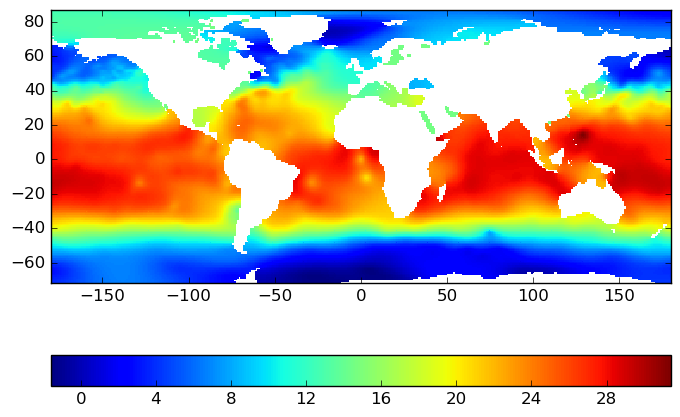

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa80f8e8dd0>

In [9]:
scalar_plot(lon,lat,v)